<a href="https://colab.research.google.com/github/hasan5352/image-recognition-Cats-v-Dogs/blob/main/catVSdogCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Drectory Set Up**

In [1]:
# First, get your api key from settings and upload the kaggle.json file in working dir
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
# directly run to get the dataset into working dir
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
100% 1.06G/1.06G [00:12<00:00, 77.7MB/s]
100% 1.06G/1.06G [00:12<00:00, 95.0MB/s]


In [3]:
!unzip /content/dogs-vs-cats.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/dogs/dog.4419.jpg  
  inflating: /content/train/dogs/dog.442.jpg  
  inflating: /content/train/dogs/dog.4420.jpg  
  inflating: /content/train/dogs/dog.4421.jpg  
  inflating: /content/train/dogs/dog.4422.jpg  
  inflating: /content/train/dogs/dog.4424.jpg  
  inflating: /content/train/dogs/dog.4425.jpg  
  inflating: /content/train/dogs/dog.4426.jpg  
  inflating: /content/train/dogs/dog.4427.jpg  
  inflating: /content/train/dogs/dog.4431.jpg  
  inflating: /content/train/dogs/dog.4433.jpg  
  inflating: /content/train/dogs/dog.4436.jpg  
  inflating: /content/train/dogs/dog.4438.jpg  
  inflating: /content/train/dogs/dog.4439.jpg  
  inflating: /content/train/dogs/dog.444.jpg  
  inflating: /content/train/dogs/dog.4440.jpg  
  inflating: /content/train/dogs/dog.4441.jpg  
  inflating: /content/train/dogs/dog.4442.jpg  
  inflating: /content/train/dogs/dog.4443.jpg  
  inflating: /content/train/dogs/dog.44

# **Imports**

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import random
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import cv2
import imghdr

# Initial Data Visualisation

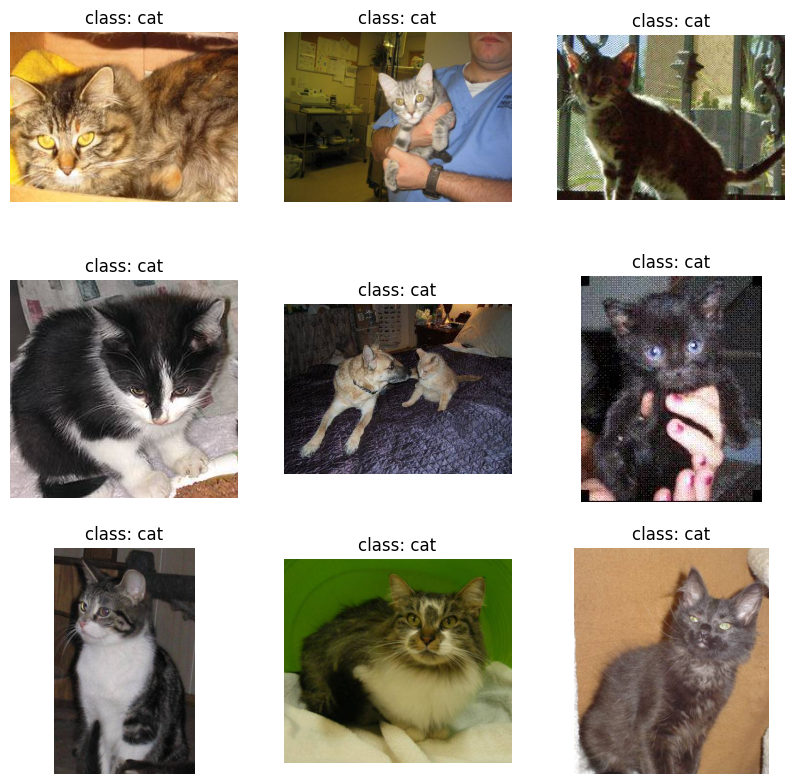

In [5]:
def plot_images_from_dir(path, animal_class, num_imgs=9):
    img_filenames = os.listdir(path)

    if len(img_filenames) < num_imgs:
        print(f"Only found {len(img_filenames)} images in {path}.")
        num_imgs = len(img_filenames)

    display_imgs = random.sample(img_filenames, num_imgs)

    fig, axes = plt.subplots(3,3, figsize=(10, 10))        # (rows,cols,figsize) | fig = whole figure | axes == matrix with each element = subplot
    axes = axes.ravel()             # flatten matrix into vector

    for i, display_img in enumerate(display_imgs):
        img_path = os.path.join(path, display_img)
        img = Image.open(img_path)
        axes[i].imshow(img)     # show rgb or grayscale img in ith subplot
        axes[i].set_title('class: '+ animal_class)      # set title of each subplot
        axes[i].axis('off')         # hide axes

cat_path = '/content/dogs_vs_cats/train/cats'
animal_class = 'cat'
plot_images_from_dir(cat_path, animal_class)

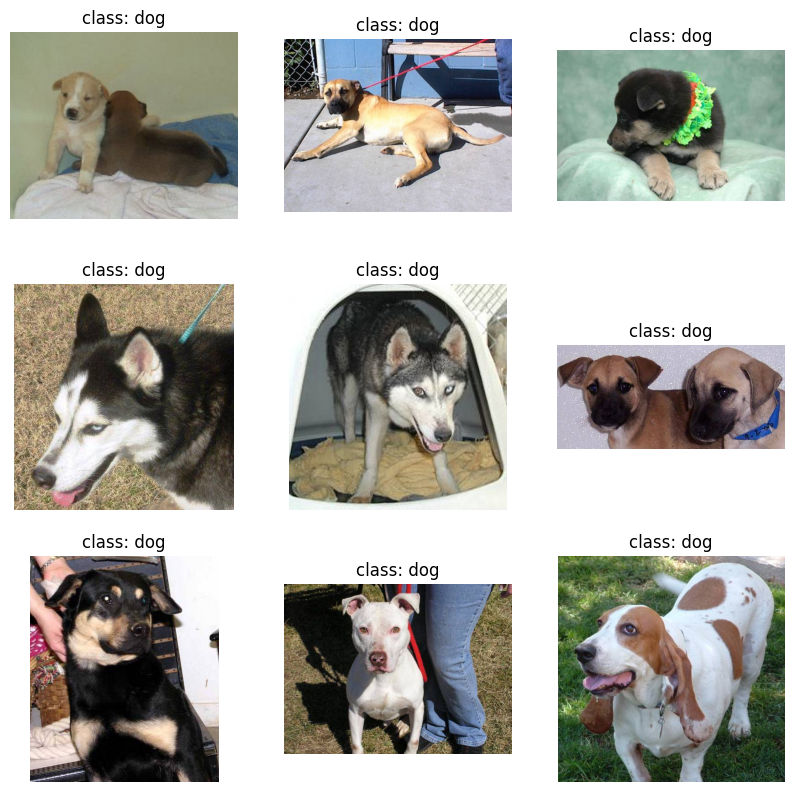

In [6]:
dog_path = '/content/dogs_vs_cats/train/dogs'
animal_class = 'dog'
plot_images_from_dir(dog_path, animal_class)

#**Data Analysis**

## drop corrupt images

In [7]:
def drop_corrupt_imgs(main_dir, image_extensions):          # acceptable image_extensions
    invalid_imgs = 0
    for sub_dir in os.listdir(main_dir):                        # go to test and train
        train_test_path = os.path.join(main_dir, sub_dir)
        for animal in os.listdir(train_test_path):             # go to dogs and cats
            animal_path = os.path.join(train_test_path, animal)
            for file_name in os.listdir(animal_path):        # go to img files
                file_path = os.path.join(animal_path, file_name)
                try:
                    file_type = imghdr.what(file_path)      # get type of current file
                    if file_type not in image_extensions:
                        invalid_imgs += 1
                        os.remove(file_path)
                except:
                    invalid_imgs += 1
                    os.remove(file_path)

    print(f"{invalid_imgs} images were corrupted and thus removed")

image_extensions = ['jpeg', 'jpg', 'png']
data_dir = '/content/dogs_vs_cats'
drop_corrupt_imgs(data_dir, image_extensions)

0 images were corrupted and thus removed


## Class distributions

Text(0.5, 1.0, 'distribution of dog and cat imgs')

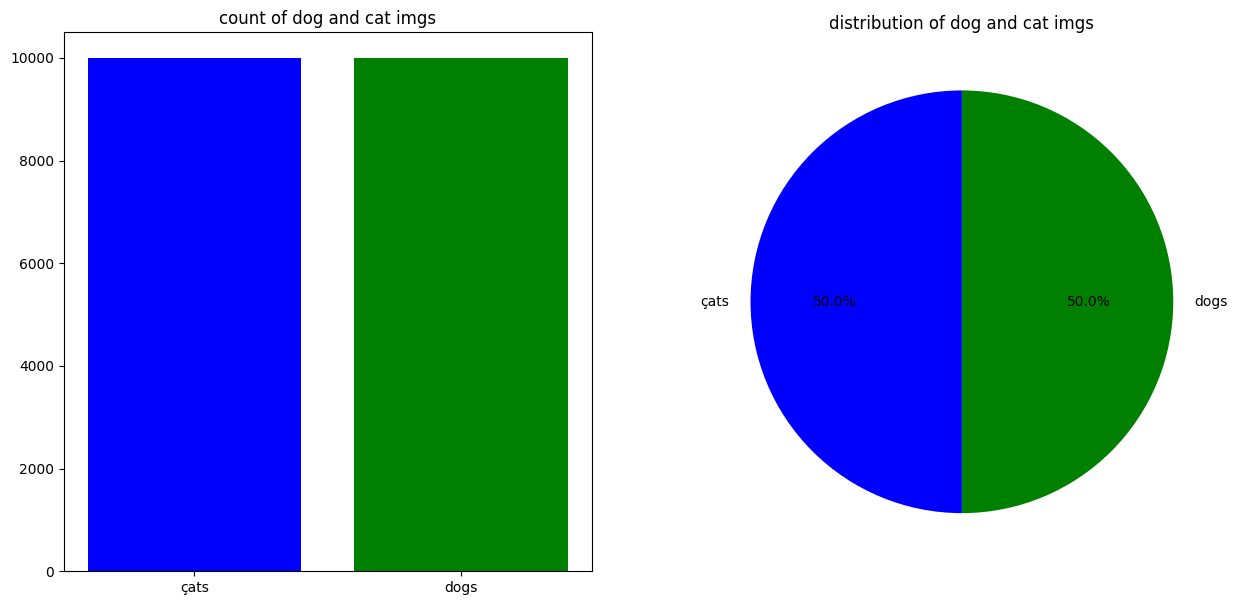

In [8]:
cat_imgs = os.listdir(cat_path)
dog_imgs = os.listdir(dog_path)

labels = ['çats', 'dogs']
count = [len(cat_imgs), len(dog_imgs)]

fig, axes = plt.subplots(1,2,figsize=(15,7))
axes[0].bar(x = labels, height=count, color=['blue', 'green'])
axes[0].set_title('count of dog and cat imgs')

axes[1].pie(x = count, labels=labels, colors=['blue', 'green'], autopct = '%1.1f%%', startangle=90)  # autopct is the percentage written inside
axes[1].set_title('distribution of dog and cat imgs')


# convert images to tensors

In [9]:
def image_to_array(image_path):
    try:
        with Image.open(image_path) as img:
           img_arr = np.array(img)
           return img_arr
    except:
        print("Error occured while converting img to tensor!")
        return None

array([[[145, 122,  70],
        [145, 122,  70],
        [144, 121,  69],
        ...,
        [213, 165, 181],
        [213, 165, 181],
        [213, 165, 181]],

       [[147, 124,  72],
        [145, 122,  70],
        [142, 119,  67],
        ...,
        [208, 160, 176],
        [208, 159, 178],
        [208, 160, 176]],

       [[146, 123,  71],
        [143, 120,  68],
        [139, 116,  64],
        ...,
        [207, 158, 177],
        [207, 158, 179],
        [207, 158, 177]],

       ...,

       [[ 18,  16,  17],
        [ 20,  18,  19],
        [ 22,  20,  21],
        ...,
        [198, 145, 163],
        [197, 144, 162],
        [196, 143, 161]],

       [[ 18,  16,  17],
        [ 20,  18,  19],
        [ 22,  20,  21],
        ...,
        [198, 145, 163],
        [197, 144, 162],
        [196, 143, 161]],

       [[ 18,  16,  17],
        [ 19,  17,  18],
        [ 21,  19,  20],
        ...,
        [198, 145, 163],
        [197, 144, 162],
        [196, 143, 161]]], dtype=uint8)
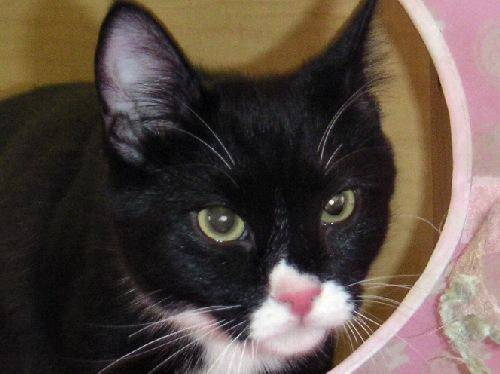

In [10]:
image_to_array("/content/dogs_vs_cats/test/cats/cat.10001.jpg")

# Data Preprocessing

## Batch Processing Generators

- encode the classes to binary.
- standardize images by resizing all to a fixed dimension
- create validation split
- normalize all pixel vals between 0 and 1  
- check how classes are encoded


In [11]:
base_dir = '/content/dogs_vs_cats/train'
VALIDATION_SIZE = 0.2
data_generator = ImageDataGenerator(            # class for generating data in batches
    rescale=1./255,                         # normalizing all pixel vals between 0 & 1
    validation_split=VALIDATION_SIZE                # splitting specified % of data for validation set
    )

BATCH_SIZE = 20
training_generator = data_generator.flow_from_directory(        # alterate simple function not using ImageDataGenerator: image_dataset_from_directory
    base_dir,                                    # get data from sub directories of base_dir
    target_size=(150, 150),                 # set all images to this size. (height, width) for uniform working of model
    subset='training',                  # which subset of training data this is: training or validation
    class_mode="binary",                 # encode labels as specified type
    batch_size=BATCH_SIZE,               # number of instances being sent to processing to Ram
)

# These generators will return: (images as tensors: list, label for each image: list) & len(these lists) = BATCH_SIZE

validation_generator = data_generator.flow_from_directory(                # get data from sub directories of base_dir
    base_dir,
    target_size=(150, 150),                 # set all images to this size. (height, width) for uniform working of model
    subset='validation',                # validation subset
    class_mode="binary",
    batch_size=BATCH_SIZE,
)

# checking how classes are encoded
training_labels = training_generator.class_indices      #class_indices gives dict as {name of parent dir of images : how it is encoded}
validation_labels = training_generator.class_indices

print(f"training_labels: {training_labels} \n validation_labels: {validation_labels}")



Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
training_labels: {'cats': 0, 'dogs': 1} 
 validation_labels: {'cats': 0, 'dogs': 1}


## Visualize imgs from batch processing

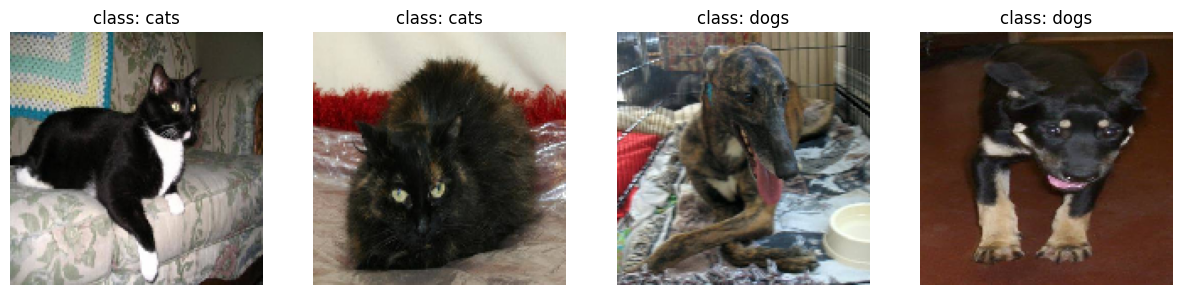

In [12]:
def plot_batch_images(generator, num_imgs=4):

    fig, axes = plt.subplots(1, num_imgs, figsize=(15,15))
    axes = axes.flatten()
    images, labels = next(generator)                             # Get a batch of images and labels from the generator
    label_encodes = training_generator.class_indices

    for i in range(num_imgs):
        axes[i].imshow(images[i])
        axes[i].set_title(f'class: {[y for y in label_encodes if label_encodes[y] == labels[i]][0]}')   # getting label name from encoding: 0 or 1 to label name
        axes[i].axis('off')

plot_batch_images(training_generator)

In [13]:
training_generator.reset()                     # reset to avoid unexpected data

# **Build CNN**

In [14]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), strides=(1, 1), activation='relu', padding="valid", input_shape = (150,150,3)),
    MaxPooling2D(pool_size=(2,2), strides=(2, 2), padding="valid"),
    Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), activation='relu', padding="valid"),
    MaxPooling2D(pool_size=(2,2), strides=(2, 2)),
    Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), activation='relu', padding="valid"),
    MaxPooling2D(pool_size=(2,2), strides=(2, 2)),
    Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), activation='relu', padding="valid"),
    MaxPooling2D(pool_size=(2,2), strides=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0